In [51]:
import os
import torch
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from glob import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [52]:
DATA_DIR = "/kaggle/input/mvtec-ad"
product_types = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]


In [53]:
train_good_images = []
test_good_images = []
test_anomaly_images = []
mask_paths = []

In [54]:
for product in product_types:
    product_dir = os.path.join(DATA_DIR, product)

    train_good_dir = os.path.join(product_dir, 'train', 'good')
    train_good_images.extend(glob(os.path.join(train_good_dir, "*.png")))

    test_dir = os.path.join(product_dir, 'test')
    test_good_dir = os.path.join(test_dir, 'good')
    test_good_images.extend(glob(os.path.join(test_good_dir, "*.png")))

    test_anomaly_dirs = [d for d in os.listdir(test_dir) if d != 'good']
    for anomaly_dir in test_anomaly_dirs:
        anomaly_images = glob(os.path.join(test_dir, anomaly_dir, "*.png"))
        
        ground_truth_dir = os.path.join(product_dir, 'ground_truth', anomaly_dir)
        for anomaly_image in anomaly_images:
            base_filename = os.path.basename(anomaly_image).replace(".png", "")
            mask_path = os.path.join(ground_truth_dir, f"{base_filename}_mask.png")
            
            if os.path.exists(mask_path):
                test_anomaly_images.append(anomaly_image)
                mask_paths.append(mask_path)
            else:
                print(f"Mask not found for {anomaly_image}")


In [55]:
print(f"Train good images: {len(train_good_images)}")
print(f"Test good images: {len(test_good_images)}")
print(f"Test anomaly images: {len(test_anomaly_images)}")
print(f"Mask paths: {len(mask_paths)}")

Train good images: 3629
Test good images: 467
Test anomaly images: 1258
Mask paths: 1258


In [56]:
import os
import requests
from zipfile import ZipFile
import glob
from dataclasses import dataclass
 
import random
import numpy as np
import cv2
 
import tensorflow as tf
import keras_cv
 
import matplotlib.pyplot as plt

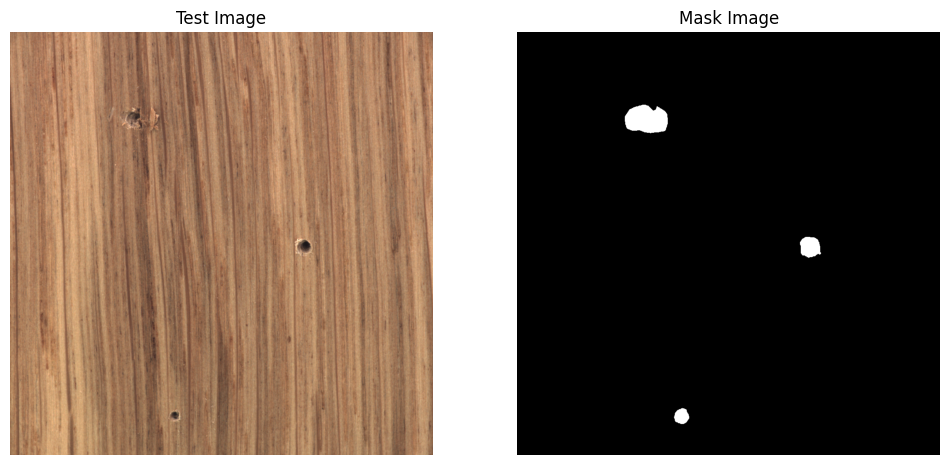

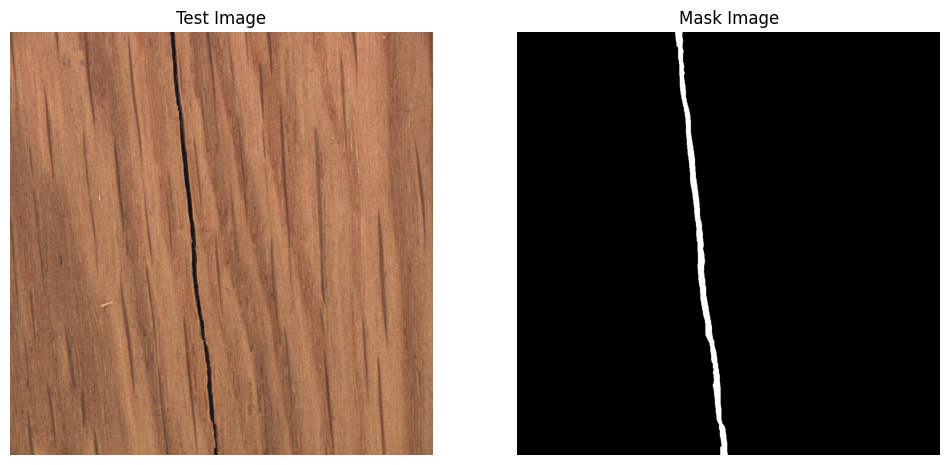

In [57]:
def show_image_and_mask(image_path, mask_path):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(image_rgb)
    ax1.set_title('Test Image')
    ax1.axis('off')
    
    ax2.imshow(mask, cmap='gray')
    ax2.set_title('Mask Image')
    ax2.axis('off')
    
    plt.show()

num_samples = 2  
for i in range(min(num_samples, len(test_anomaly_images))):
    show_image_and_mask(test_anomaly_images[i], mask_paths[i])

In [58]:
org_data = tf.data.Dataset.from_tensor_slices((test_anomaly_images, mask_paths))

In [59]:
SPLIT_RATIO = 0.2
NUM_VAL = int(len(test_anomaly_images) * SPLIT_RATIO)
 
train_data = org_data.skip(NUM_VAL)
valid_data = org_data.take(NUM_VAL)

In [60]:
@dataclass(frozen=True)
class DatasetConfig:
    IMAGE_SIZE:        tuple = (256, 256)
    BATCH_SIZE:          int = 16
    NUM_CLASSES:         int = 2
    BRIGHTNESS_FACTOR: float = 0.2
    CONTRAST_FACTOR:   float = 0.2

In [61]:
def read_image_mask(image_path, mask=False, size = DatasetConfig.IMAGE_SIZE):
    image = tf.io.read_file(image_path)
 
    if mask:
        image = tf.io.decode_image(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=size, method = "bicubic")
 
        image_mask = tf.zeros_like(image)
        cond = image >=200
        updates = tf.ones_like(image[cond])
        image_mask = tf.tensor_scatter_nd_update(image_mask, tf.where(cond), updates)
        image = tf.cast(image_mask, tf.uint8)
 
    else:
        image = tf.io.decode_image(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=size, method = "bicubic")
        image = tf.cast(tf.clip_by_value(image, 0., 255.), tf.float32)
 
    return image

In [62]:
def load_data(image_list, mask_list):
    image = read_image_mask(image_list)
    mask  = read_image_mask(mask_list, mask=True)
    return {"images":image, "segmentation_masks":mask}

In [63]:
train_ds = train_data.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_data.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)

In [64]:
id2color = {
    0: (0,  0,    0),  
    1: (255, 255, 255),
 }

In [65]:
def num_to_rgb(num_arr, color_map=id2color):
     
    # single_layer = np.squeeze(num_arr)
    output = np.zeros(num_arr.shape[:2]+(3,))
     
    for k in color_map.keys():
        output[num_arr==k] = color_map[k]
         
    return output.astype(np.uint8)

In [66]:
def image_overlay(image, segmented_image):
 
    alpha = 1.0 
    beta  = 0.7 
    gamma = 0.0
 
    image = image.astype(np.uint8)
 
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
 
    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
    return image

In [67]:
def display_image_and_mask(data_list, title_list, figsize, color_mask=False, color_map=id2color):
     
    rgb_gt_mask = num_to_rgb(data_list[1], color_map=color_map)
    mask_to_overlay = rgb_gt_mask
 
    if len(data_list)==3:
        rgb_pred_mask = num_to_rgb(data_list[-1], color_map=color_map)
        mask_to_overlay = rgb_pred_mask
         
    overlayed_image = image_overlay(data_list[0], mask_to_overlay)
     
    data_list.append(overlayed_image)
 
    fig, axes = plt.subplots(nrows=1, ncols=len(data_list), figsize=figsize)
     
    for idx, axis in enumerate(axes.flat):
        axis.set_title(title_list[idx])
        if title_list[idx] == "GT Mask":
            if color_mask:
                axis.imshow(rgb_gt_mask)
            else:
                axis.imshow(data_list[1], cmap="gray")
 
        elif title_list[idx] == "Pred Mask":
            if color_mask:
                axis.imshow(rgb_pred_mask)
            else:
                axis.imshow(data_list[-1], cmap="gray")
             
        else:
            axis.imshow(data_list[idx])
             
        axis.axis('off')
         
    plt.show()

In [68]:
def unpackage_inputs(inputs):
    images = inputs["images"]
    segmentation_masks = inputs["segmentation_masks"]
    return images, segmentation_masks

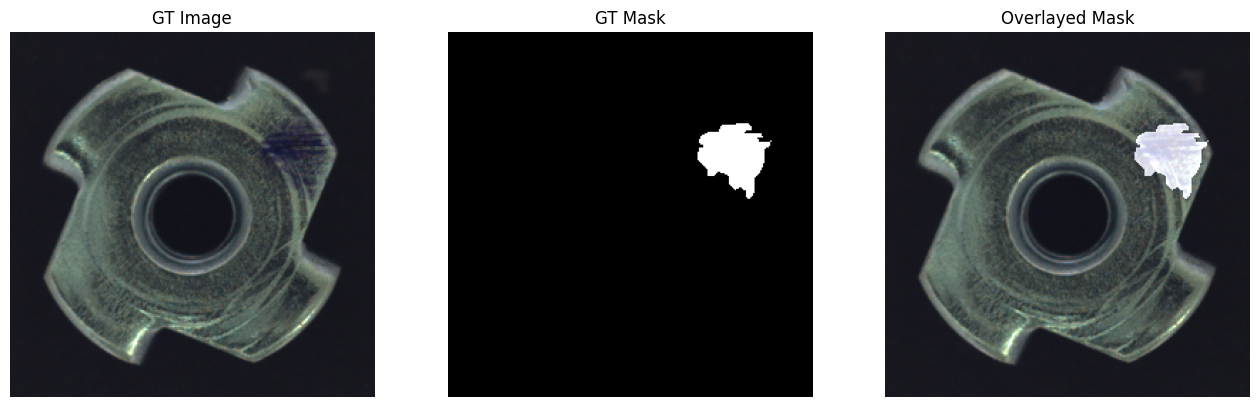

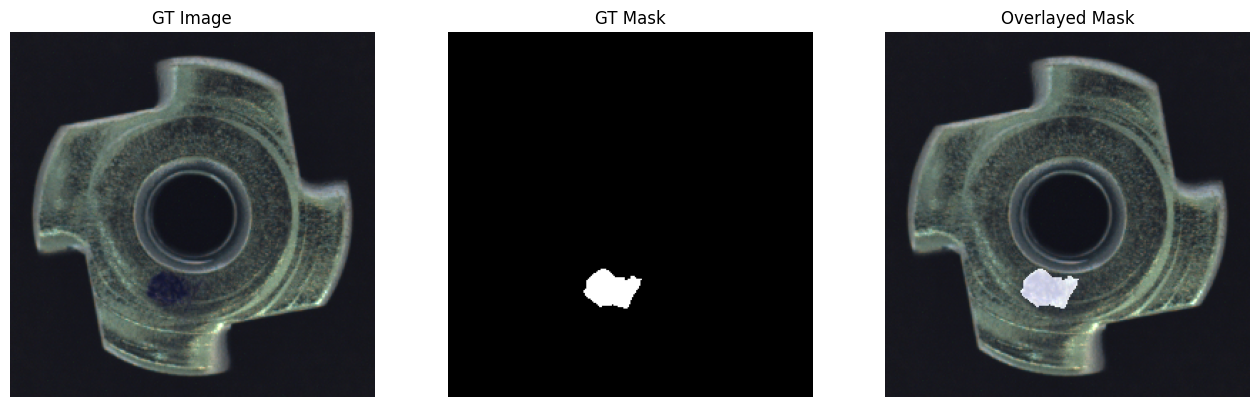

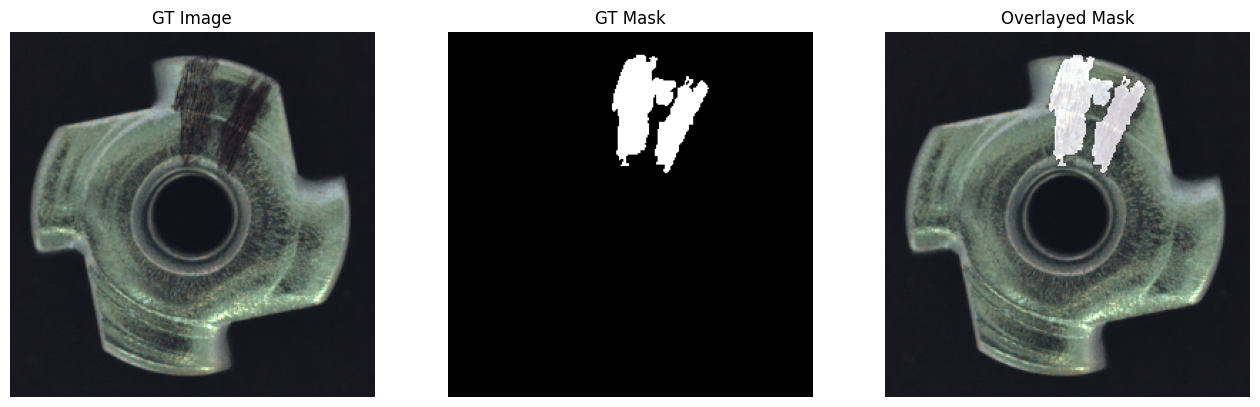

In [69]:
plot_train_ds = train_ds.map(unpackage_inputs).batch(3)
image_batch, mask_batch = next(iter(plot_train_ds.take(1)))
 
titles = ["GT Image", "GT Mask", "Overlayed Mask"]
 
for image, gt_mask in zip(image_batch, mask_batch):
 
    gt_mask = tf.squeeze(gt_mask, axis=-1).numpy()
    display_image_and_mask([image.numpy().astype(np.uint8), gt_mask], 
                           title_list=titles,
                           figsize=(16,6),
                           color_mask=True)

In [70]:
augment_fn = tf.keras.Sequential(
    [
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.RandomBrightness(factor=DatasetConfig.BRIGHTNESS_FACTOR,
                                         value_range=(0, 255)),
        keras_cv.layers.RandomContrast(factor=DatasetConfig.CONTRAST_FACTOR,
                                       value_range=(0, 255)),
    ]
)

In [71]:
train_dataset = (
                train_ds.shuffle(DatasetConfig.BATCH_SIZE)
                .map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
                .batch(DatasetConfig.BATCH_SIZE)
                .map(unpackage_inputs)
                .prefetch(buffer_size=tf.data.AUTOTUNE)
)
 
valid_dataset = (
                valid_ds.batch(DatasetConfig.BATCH_SIZE)
                .map(unpackage_inputs)
                .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [72]:
@dataclass(frozen=True)
class TrainingConfig:
    MODEL:           str = "resnet50_v2_imagenet"
    EPOCHS:          int = 10
    LEARNING_RATE: float = 1e-4
    CKPT_DIR:        str = os.path.join("checkpoints_"+"_".join(MODEL.split("_")[:2]), 
                                        "deeplabv3_plus_"+"_".join(MODEL.split("_")[:2])+".weights.h5")
    LOGS_DIR:        str = "logs_"+"_".join(MODEL.split("_")[:2])


In [73]:
backbone = keras_cv.models.ResNet50V2Backbone.from_preset(preset = TrainingConfig.MODEL,
                                                          input_shape=DatasetConfig.IMAGE_SIZE+(3,),
                                                          load_weights = True)
model = keras_cv.models.segmentation.DeepLabV3Plus(
        num_classes=DatasetConfig.NUM_CLASSES, backbone=backbone,
    )

In [74]:
def get_callbacks(
    train_config,
    monitor="val_mean_iou",
    mode="max",
    save_weights_only=True,
    save_best_only=True,
):
 
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=train_config.LOGS_DIR,
        histogram_freq=20,
        write_graph=False,
        update_freq="epoch",
    )
 
 
    if save_weights_only:
        checkpoint_filepath = train_config.CKPT_DIR
 
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=save_weights_only,
        monitor=monitor,
        mode=mode,
        save_best_only=save_best_only,
        verbose=1,
    )
 
    return [tensorboard_callback, model_checkpoint_callback]

In [75]:
def mean_iou(y_true, y_pred):
 
    num_classes = y_pred.shape[-1]
 
    y_true = tf.squeeze(y_true, axis=-1)
 
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes, axis=-1)
    y_pred = tf.one_hot(tf.math.argmax(y_pred, axis=-1), num_classes, axis=-1)
 
    intersection = tf.math.reduce_sum(y_true * y_pred, axis=(1, 2))
 
    total = tf.math.reduce_sum(y_true, axis=(1, 2)) + tf.math.reduce_sum(y_pred, axis=(1, 2))
 
    union = total - intersection
 
    is_class_present =  tf.cast(tf.math.not_equal(total, 0), dtype=tf.float32)
    num_classes_present = tf.math.reduce_sum(is_class_present, axis=1)
 
    iou = tf.math.divide_no_nan(intersection, union)
    iou = tf.math.reduce_sum(iou, axis=1) / num_classes_present
 
    mean_iou = tf.math.reduce_mean(iou)
 
    return mean_iou

In [76]:
callbacks = get_callbacks(TrainingConfig)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(
    optimizer=tf.keras.optimizers.Adam(TrainingConfig.LEARNING_RATE),
    loss=loss_fn,
    metrics=["accuracy", mean_iou],
)

In [77]:
history = model.fit(
    train_dataset,
    epochs=TrainingConfig.EPOCHS,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 993ms/step - accuracy: 0.3410 - loss: 1.1614 - mean_iou: 0.1778
Epoch 1: val_mean_iou improved from -inf to 0.39310, saving model to checkpoints_resnet50_v2/deeplabv3_plus_resnet50_v2.weights.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.3456 - loss: 1.1544 - mean_iou: 0.1802 - val_accuracy: 0.7740 - val_loss: 1.4393 - val_mean_iou: 0.3931
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 997ms/step - accuracy: 0.9716 - loss: 0.2005 - mean_iou: 0.4920
Epoch 2: val_mean_iou improved from 0.39310 to 0.44948, saving model to checkpoints_resnet50_v2/deeplabv3_plus_resnet50_v2.weights.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9714 - loss: 0.2005 - mean_iou: 0.4921 - val_accuracy: 0.8936 - val_loss: 0.5292 - val_mean_iou: 0.4495
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 990ms/step - accuracy: 0.9744 - loss: 0.1377 - mean_iou: 0.5023
Epoch 3: val_mean_iou improved from 0.44948 to 0.46364, saving model to checkpoints_resnet50_v2/deeplabv3

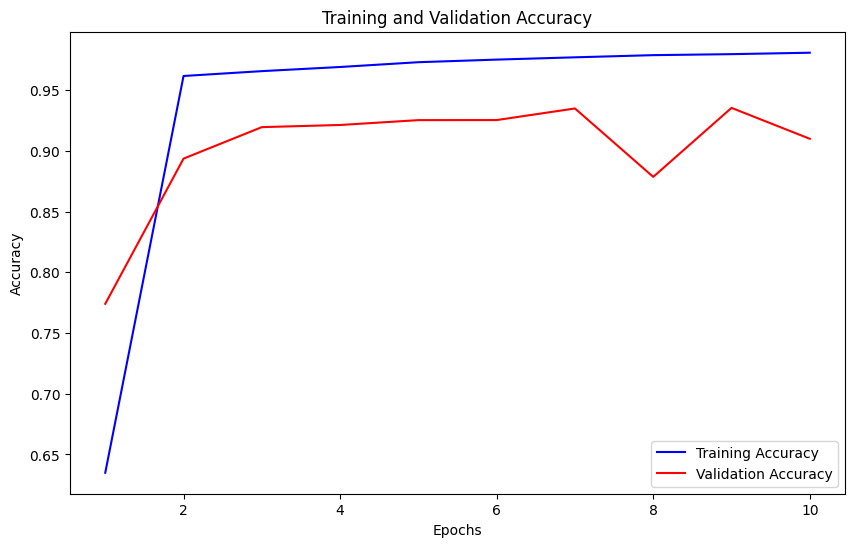

In [78]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [79]:
def inference(model, dataset, samples_to_plot):
 
    num_batches_to_process = 2
    count = 0
    stop_plot = False
 
    titles = ["Image", "GT Mask", "Pred Mask", "Overlayed Prediction"]
 
    for idx, data in enumerate(dataset):
 
        if stop_plot:
            break
 
        batch_img, batch_mask = data[0], data[1]
        batch_pred = (model.predict(batch_img)).astype('float32')
        batch_pred = batch_pred.argmax(axis=-1)
         
        batch_img  = batch_img.numpy().astype('uint8')
        batch_mask = batch_mask.numpy().squeeze(axis=-1)
 
        for image, mask, pred in zip(batch_img, batch_mask, batch_pred):
            count+=1
            display_image_and_mask([image, mask, pred],
                                  title_list=titles,
                                   figsize=(20,8),
                                   color_mask=True)
            if count >= samples_to_plot:
                stop_plot=True
                break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


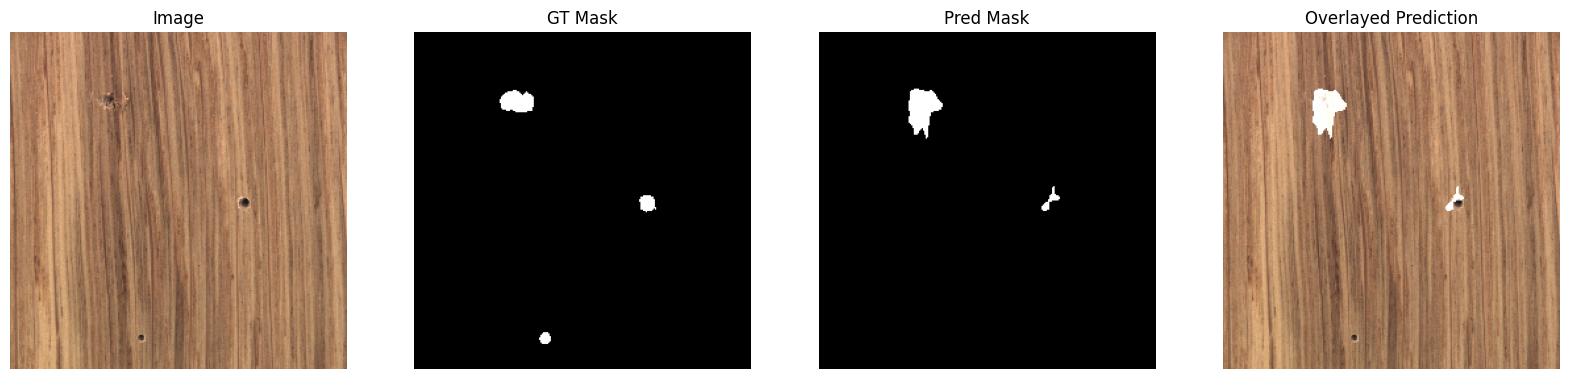

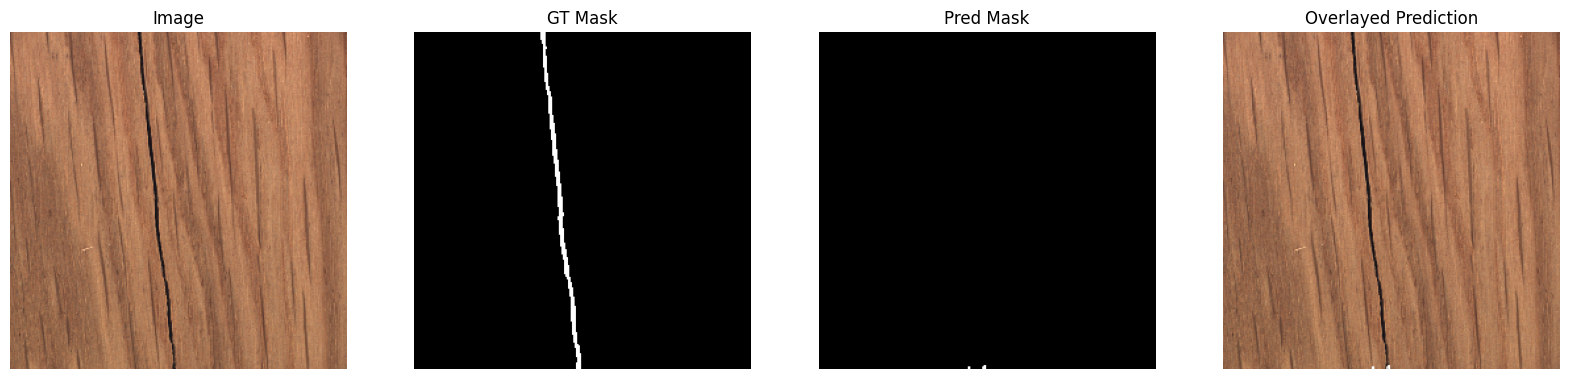

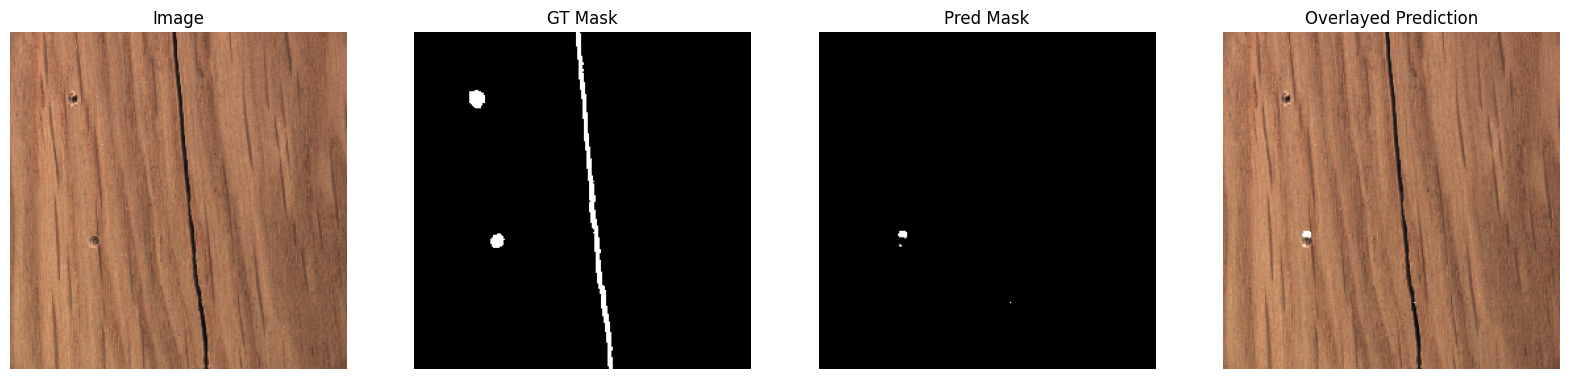

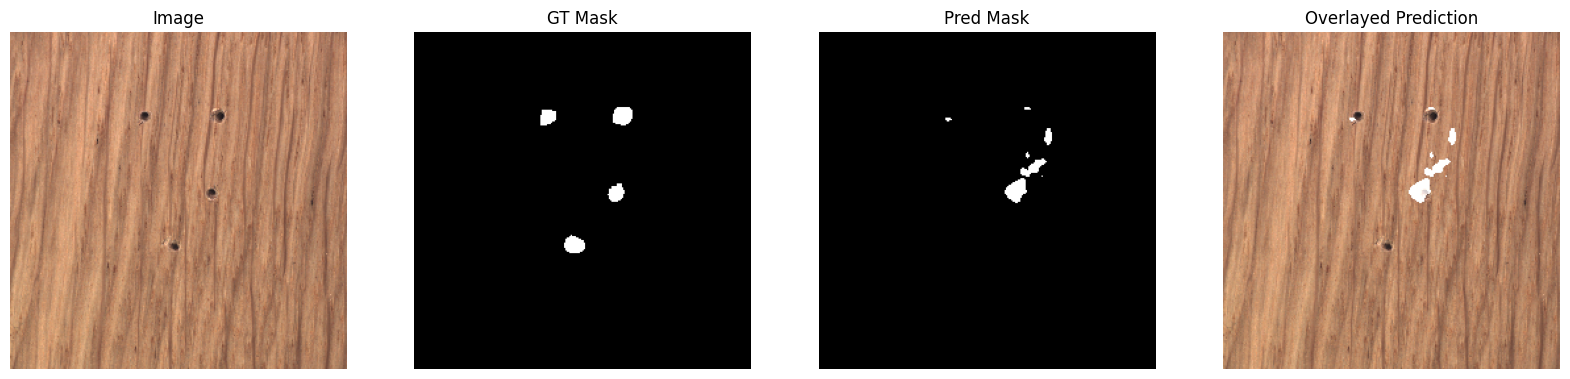

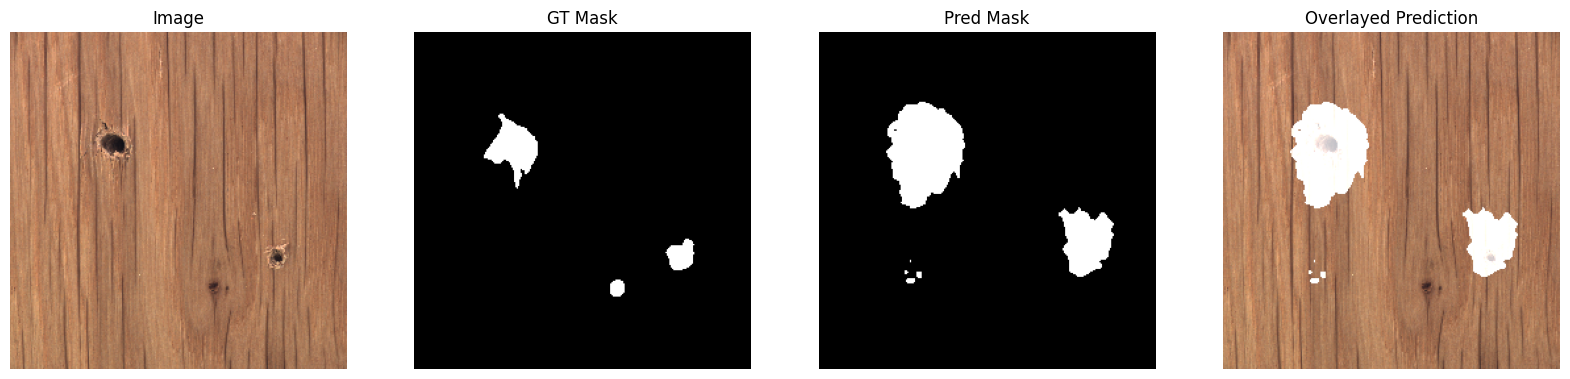

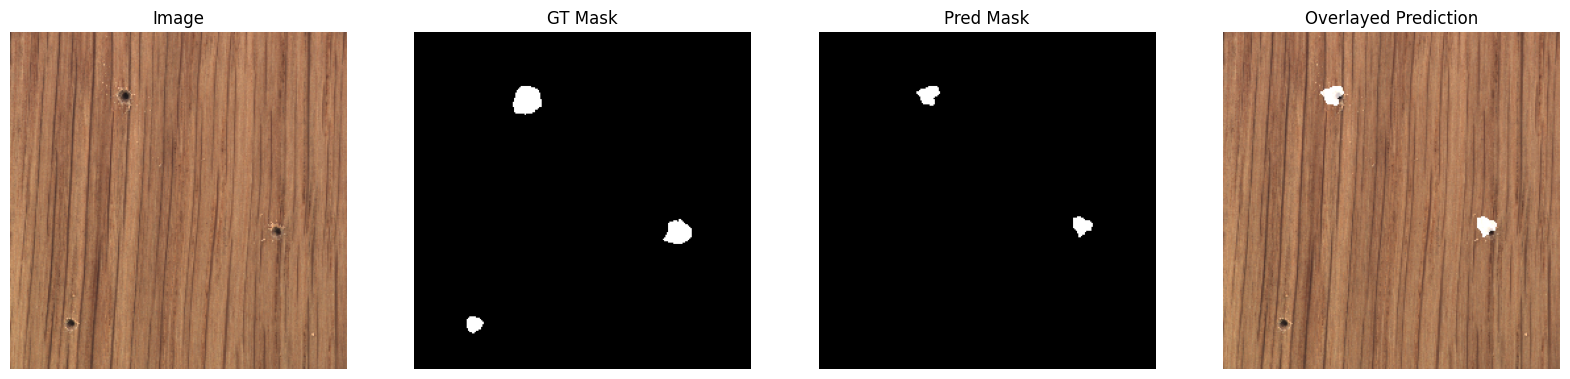

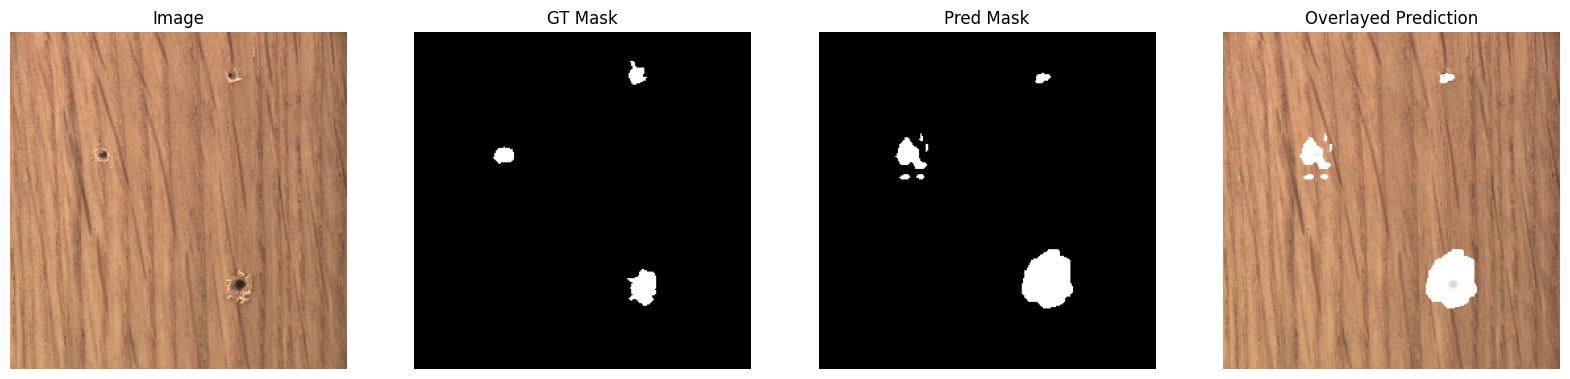

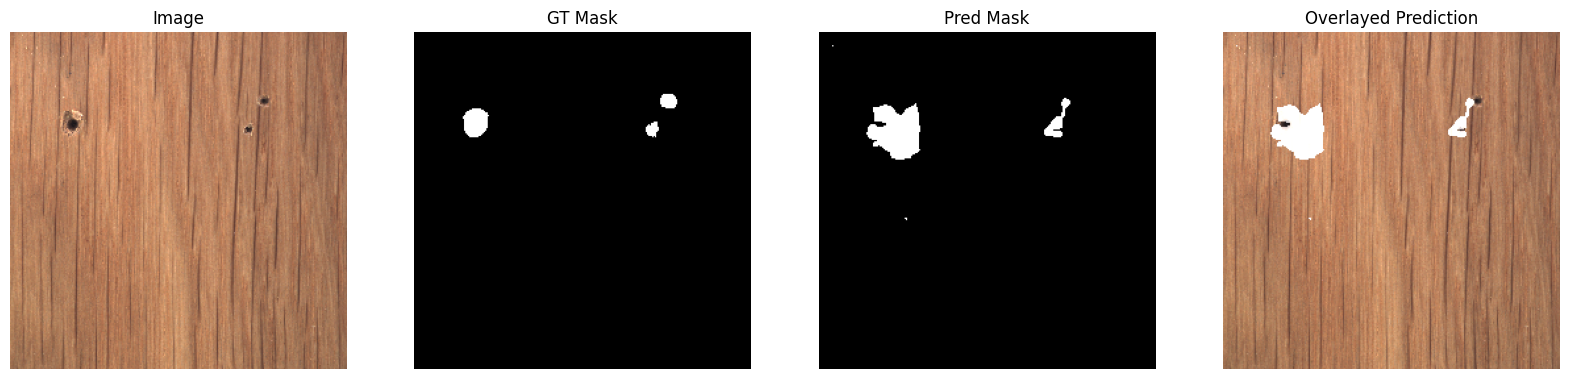

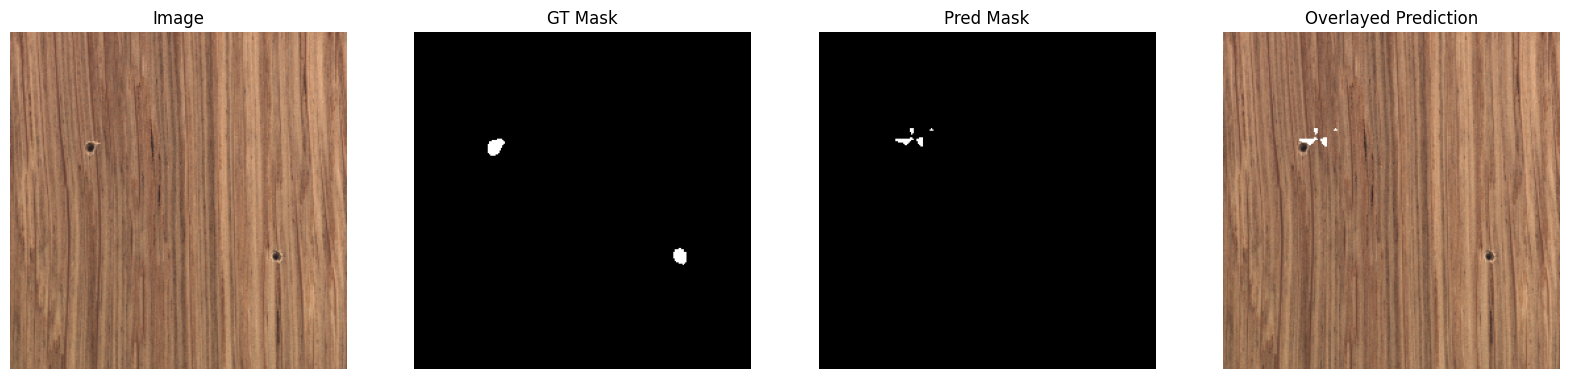

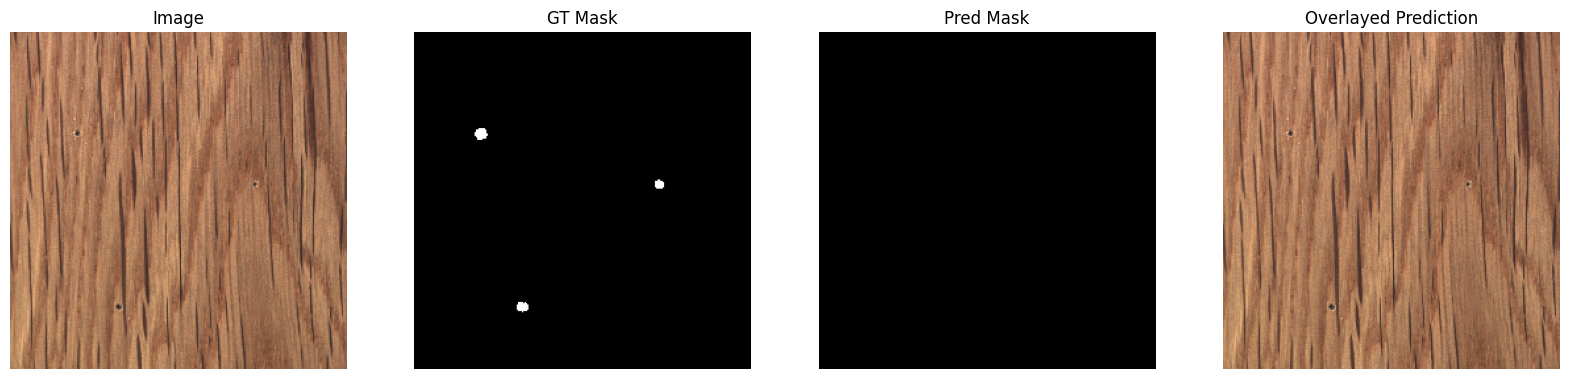

In [82]:
inference(model, valid_dataset, 10)

In [83]:
model.save('my_model.h5')